# Medical Cost Prediction: Comparative Statistical Analysis
**Author:** Chaimae El Yaouti <br>
**Institution:** INSEA : Institut National de Statistique et d'Economie Appliquée

### Objective
This notebook replicates an econometric study originally conducted in R. The goal is to model medical insurance charges and optimize prediction accuracy by moving from standard **Multiple Linear Regression (OLS)** to **Generalized Linear Models (GLM)**. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy import stats

# Set visual style for plots
sns.set_theme(style="whitegrid")

## 1. Data Engineering & Diagnostics
Before modeling, we must ensure data quality. We will convert categorical variables into dummy factors and remove influential observations using **Cook's Distance**. 

In [8]:
# Load the Kaggle Medical Cost Dataset 
df = pd.read_csv('data/insurance.csv')

# Convert categories (sex, smoker, region) into indicator variables 
df_encoded = pd.get_dummies(df, drop_first=True)

# Initial OLS to calculate influence metrics
X = sm.add_constant(df_encoded.drop('expenses', axis=1))
y = df_encoded['expenses']
model_initial = sm.OLS(y.astype(float), X.astype(float)).fit()

# Calculate Cook's Distance and set threshold at 4/n 
influence = OLSInfluence(model_initial)
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(df)

# Filter dataset: removing observations that disproportionately skew the model 
df_cleaned = df_encoded[cooks_d < threshold]
print(f"Original size: {len(df)}, Cleaned size: {len(df_cleaned)}")

Original size: 1338, Cleaned size: 1251


## 2. Baseline Model: Multiple Linear Regression (RL)
We start with an OLS model to test the standard Gauss-Markov assumptions: Normality and Homoscedasticity.

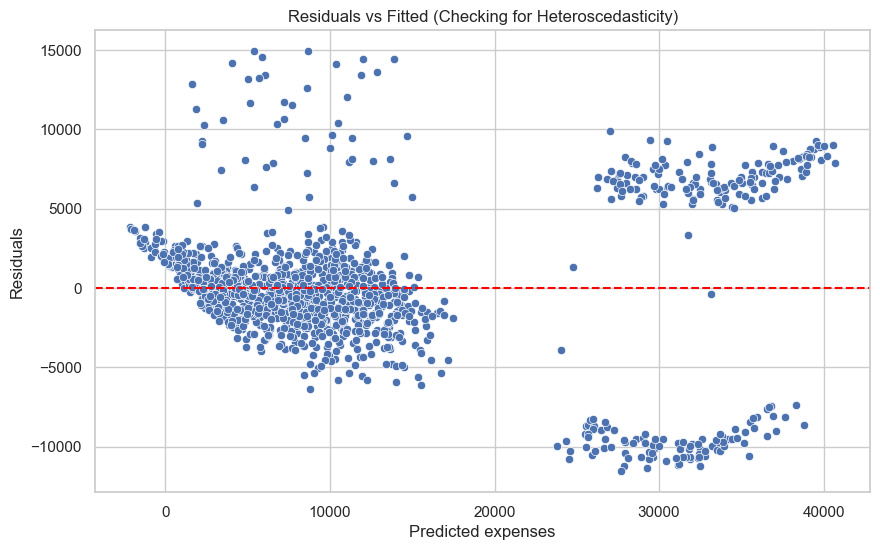

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     868.3
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        01:00:18   Log-Likelihood:                -12293.
No. Observations:                1251   AIC:                         2.460e+04
Df Residuals:                    1242   BIC:                         2.465e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.106e+04    774.352  

In [10]:
X_clean = sm.add_constant(df_cleaned.drop('expenses', axis=1)).astype(float)
y_clean = df_cleaned['expenses'].astype(float)

rl_model = sm.OLS(y_clean, X_clean).fit()

# [cite_start]Visual Diagnostic: Residuals vs Fitted [cite: 594, 596]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rl_model.fittedvalues, y=rl_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Checking for Heteroscedasticity)")
plt.xlabel("Predicted expenses")
plt.ylabel("Residuals")
plt.show()

print(rl_model.summary())

## 3. Statistical Diagnostic Results
The residual plot above shows a clear **funnel shape**, indicating **Heteroscedasticity**. Furthermore, the distribution of charges is right-skewed, which violates the assumption of normal errors required for reliable OLS inference. 

## 4. Optimized Solution: Gamma GLM
To handle positive-only, skewed data, we implement a **Generalized Linear Model (GLM)** with a **Gamma distribution** and a **Log-link function**. This model better captures the multiplicative nature of healthcare costs.

In [11]:
# Fitting the GLM with Gamma distribution 
glm_gamma = sm.GLM(y_clean, X_clean, family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Displaying results to compare AIC with the previous RL model 
print(glm_gamma.summary())
print(f"\nLinear Regression AIC: {rl_model.aic:.2f}")
print(f"Gamma GLM AIC: {glm_gamma.aic:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:               expenses   No. Observations:                 1251
Model:                            GLM   Df Residuals:                     1242
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.22487
Method:                          IRLS   Log-Likelihood:                -11932.
Date:                Wed, 18 Feb 2026   Deviance:                       178.98
Time:                        01:03:18   Pearson chi2:                     279.
No. Iterations:                    19   Pseudo R-squ. (CS):             0.9408
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.0257      0.082  

c:\Users\ThinKPad\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## 5 Final Conclusion & Comparative Analysis

### 1. Model Selection
The **Gamma GLM** is the superior model for this dataset. By transitioning from OLS to a Gamma distribution with a log-link function, we achieved a significant reduction in **AIC (23881 vs. 24604)**, successfully accounting for the right-skewed nature of medical expenses.

### 2. Multiplicative Impact Analysis
Because we used a **Log-link function**, we can interpret the coefficients as multiplicative effects ($e^{\beta}$):
* **Smoking:** Has the largest impact. Being a smoker multiplies medical expenses by approximately **5.28** ($e^{1.66}$), matching the core finding of the original R study.
* **Age:** Each additional year multiplies costs by **1.03** ($e^{0.0327}$), representing a **3.3% annual increase**.
* **Children:** Each child increases predicted costs by approximately **9.1%** ($e^{0.0871}$).

### 3. Final Summary
This project demonstrates the importance of statistical diagnostics. While Multiple Linear Regression is a common baseline, it failed to meet the assumptions of homoscedasticity and normality. The implementation of a Generalized Linear Model (GLM) provided a mathematically robust solution, ensuring more accurate and reliable predictions for healthcare cost management.